In [4]:
import numpy as np
import struct
import csv
import glob

# Define grid dimensions and parameters
lat_grid_size = 480  # 60°S to 60°N
lon_grid_size = 1440  # 0° to 360°
latitudes = np.linspace(-60, 60, lat_grid_size)
longitudes = np.linspace(0, 360, lon_grid_size, endpoint=False)

# Create a list to store all data for all time periods
all_data = []

# Path to the folder containing .bin files
file_path = "rain/*.bin"  # Adjust the path as needed

# Iterate over all .bin files in the specified directory
for file_name in glob.glob(file_path):
    with open(file_name, "rb") as file:
        # Read the entire file into a buffer
        data = file.read()
        num_values = len(data) // 4  # 4 bytes per float32
        rainfall_data = struct.unpack('f' * num_values, data)  # unpack as float32

    # Convert data into a NumPy array and reshape it to (lat_grid_size, lon_grid_size)
    rainfall_array = np.array(rainfall_data).reshape((lat_grid_size, lon_grid_size))
    
    # Filter for every 5-degree change in latitude (indices corresponding to every 5 degrees)
    for i in range(0, lat_grid_size, 40):  # 20 indices corresponds to 5 degrees (0.25° resolution)
        for j in range(lon_grid_size):
            # Prepare the data row with Latitude, Longitude, and Rainfall
            all_data.append([latitudes[i], longitudes[j], rainfall_array[i, j]])

# Export all collected data to a single CSV file
with open("rainfall_data_all_periods.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Latitude", "Longitude", "Rainfall (mm/hr)"])
    writer.writerows(all_data)

print("Data processing complete! The combined data is saved in 'rainfall_data_all_periods.csv'.")


Data processing complete! The combined data is saved in 'rainfall_data_all_periods.csv'.


In [2]:
import rasterio
import pandas as pd
import numpy as np

# Path to the .tif file
tif_file = 'rain/PERSIANN_1y2005.tif'

# Open the .tif file using rasterio
with rasterio.open(tif_file) as src:
    # Read the data into a numpy array
    rainfall_data = src.read(1)  # Read the first band

    # Get the metadata
    meta = src.meta

# Display some metadata
print(meta)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99.0, 'width': 119, 'height': 173, 'count': 1, 'crs': None, 'transform': Affine(0.25, 0.0, 68.0,
       0.0, -0.25, 35.75)}


In [3]:
# Get the dimensions of the data
rows, cols = rainfall_data.shape

# Create a DataFrame to hold the data
data = {
    'Row': [],
    'Col': [],
    'Rainfall (mm)': []
}

# Populate the DataFrame
for row in range(rows):
    for col in range(cols):
        # Only save non-null (or non-missing) values
        if rainfall_data[row, col] is not None and rainfall_data[row, col] != 0:
            data['Row'].append(row)
            data['Col'].append(col)
            data['Rainfall (mm)'].append(rainfall_data[row, col])

# Create the DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('rainfall_data.csv', index=False)

print("Data saved to rainfall_data.csv")


Data saved to rainfall_data.csv


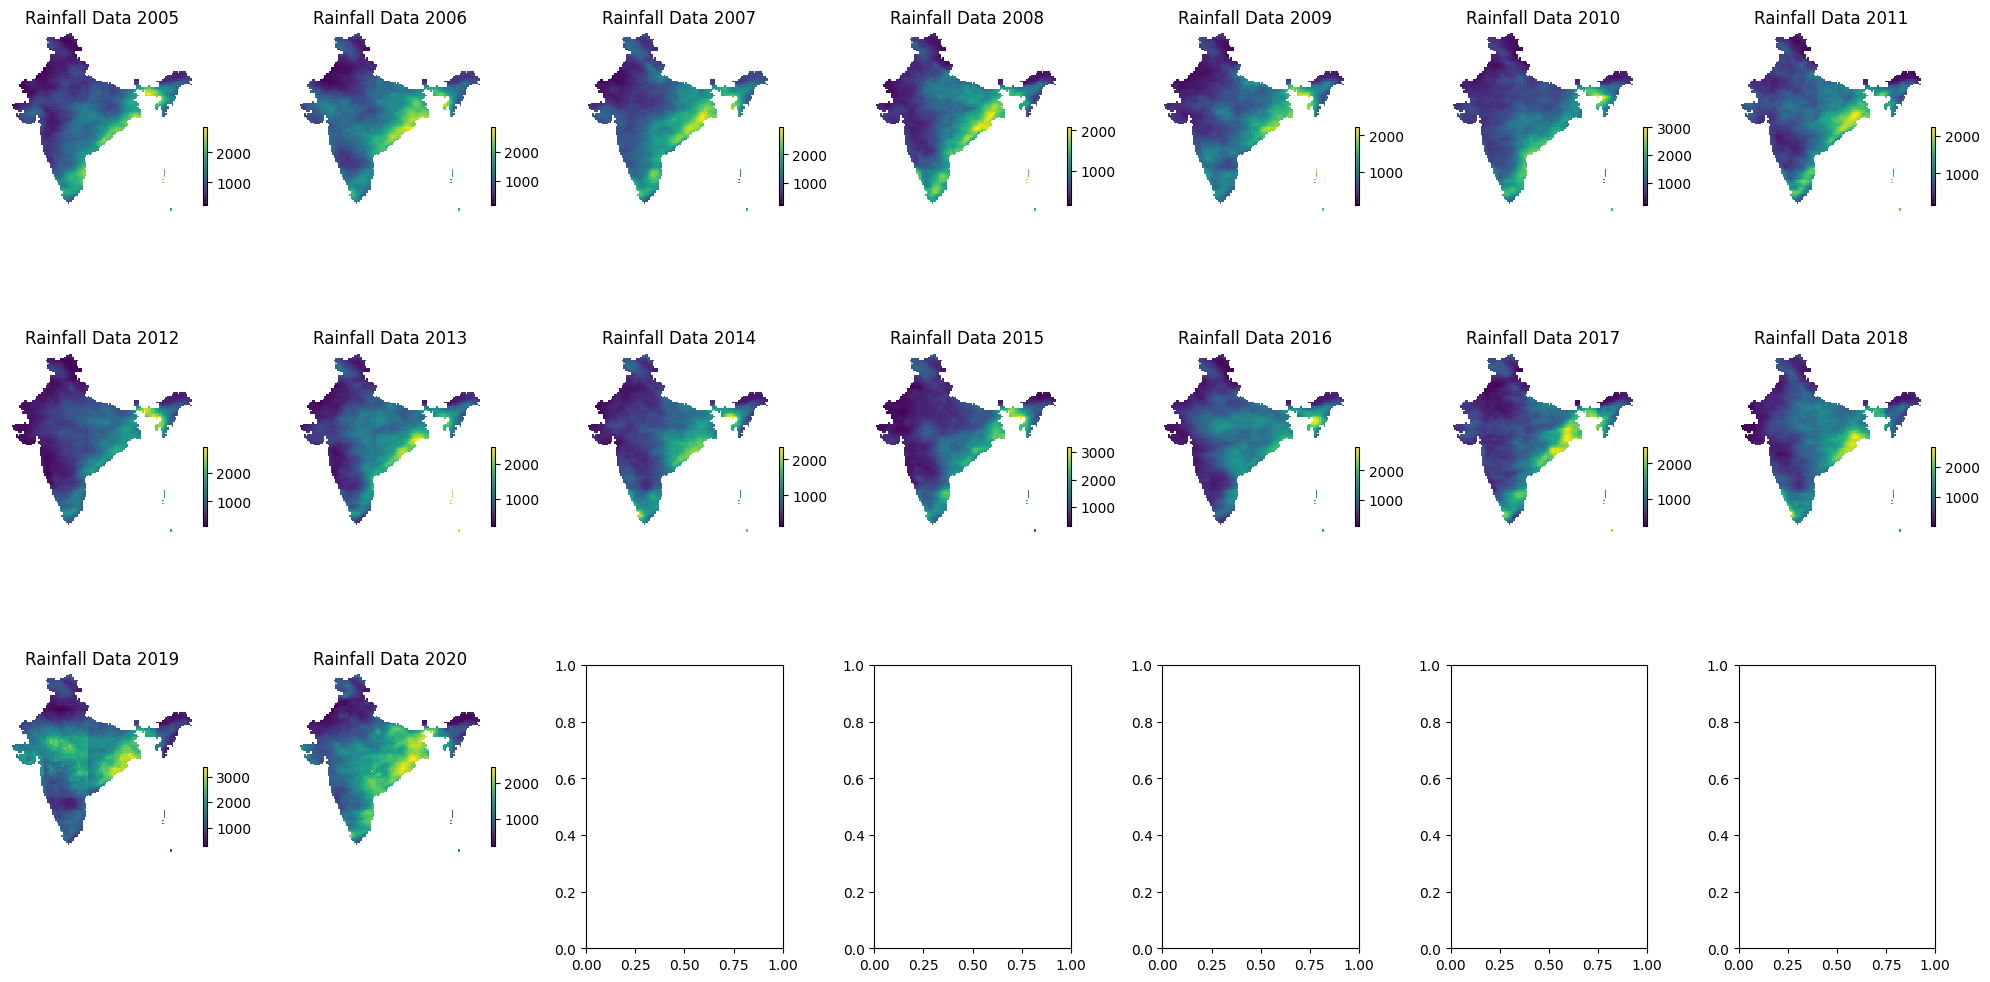

In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the years you want to process
years = range(2005, 2021)

# Create a figure for visualization
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(20, 10))  # Adjust as necessary
axes = axes.flatten()  # Flatten the axes for easy indexing

# Loop through each year
for i, year in enumerate(years):
    # Construct the filename for each year
    tif_file = f'rain/PERSIANN_1y{year}.tif'  # Make sure this path is correct

    try:
        # Open the .tif file using rasterio
        with rasterio.open(tif_file) as src:
            # Read the data into a numpy array
            rainfall_data = src.read(1)  # Read the first band

        # Mask no-data values
        rainfall_data[rainfall_data == src.nodata] = np.nan

        # Plot the rainfall data
        ax = axes[i]
        img = ax.imshow(rainfall_data, cmap='viridis', interpolation='nearest')
        ax.set_title(f'Rainfall Data {year}')
        ax.axis('off')  # Hide axes

        # Add colorbar
        plt.colorbar(img, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

    except Exception as e:
        print(f"Could not read {tif_file}: {e}")

# Adjust layout
plt.tight_layout()
plt.show()


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99.0, 'width': 119, 'height': 173, 'count': 1, 'crs': None, 'transform': Affine(0.25, 0.0, 68.0,
       0.0, -0.25, 35.75)}


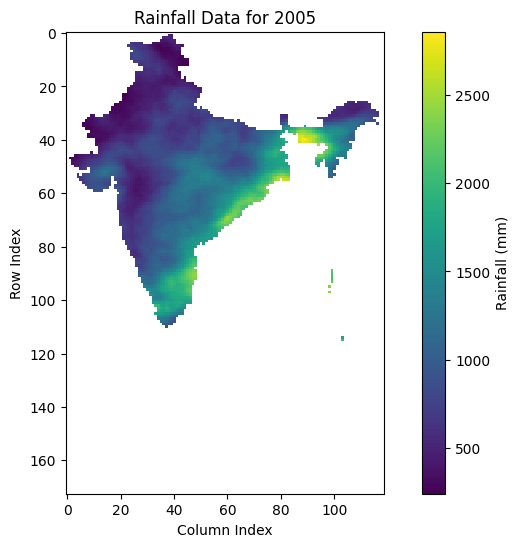

In [8]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the TIF file
tif_file = 'rain/PERSIANN_1y2005.tif'

# Open the .tif file using rasterio
with rasterio.open(tif_file) as src:
    # Read the data into a numpy array
    rainfall_data = src.read(1)  # Read the first band

    # Get the metadata (optional)
    meta = src.meta
    print(meta)

# Masking no-data values if applicable
rainfall_data[rainfall_data == src.nodata] = np.nan

# Plotting the rainfall data
plt.figure(figsize=(10, 6))
plt.imshow(rainfall_data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Rainfall (mm)')  # Add a color bar
plt.title('Rainfall Data for 2005')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Load the district flooded area data
district_df = pd.read_csv("District_FloodedArea.csv")

# Load rainfall data
rainfall_df = pd.read_csv("rainfall_data_all_periods.csv")

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapi")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Create empty lists for matched coordinates
district_df['Latitude'] = None
district_df['Longitude'] = None

# Geocode districts to get approximate coordinates
for i, row in district_df.iterrows():
    location = geocode(row['Dist_Name'])
    if location:
        district_df.at[i, 'Latitude'] = location.latitude
        district_df.at[i, 'Longitude'] = location.longitude
    else:
        print(f"Coordinates not found for {row['Dist_Name']}")


Coordinates not found for Nicobars
Coordinates not found for Sri Potti Sriramulu Nell*
Coordinates not found for South Salmara Mancachar
Coordinates not found for Dakshin Bastar Dantewada
Coordinates not found for Kabeerdham
Coordinates not found for Bametara
Coordinates not found for Charki Dadri
Coordinates not found for Shupiyan
Coordinates not found for Purbi Singhbhum
Coordinates not found for Pashchimi Singhbhum
Coordinates not found for Sahibzada Ajit Singh Nag*
Coordinates not found for Unokoti
Coordinates not found for South Twenty Four Pargan*
Coordinates not found for North Twenty Four Pargan*


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [2]:
# Define function to find closest rainfall data based on coordinates
def find_closest_rainfall(lat, lon):
    # Filter out cases where latitude or longitude is None
    if pd.isna(lat) or pd.isna(lon):
        return None
    # Calculate approximate matches by finding the minimum distance
    distances = ((rainfall_df['Latitude'] - lat)**2 + (rainfall_df['Longitude'] - lon)**2)
    closest_idx = distances.idxmin()
    return rainfall_df.loc[closest_idx, 'Rainfall (mm/hr)']

# Apply the matching function for each row in the district data
district_df['Rainfall (mm/hr)'] = district_df.apply(
    lambda row: find_closest_rainfall(row['Latitude'], row['Longitude']), axis=1
)

# Save the merged result to a new CSV
district_df.to_csv("Merged_District_Rainfall_Data.csv", index=False)

print("Merged CSV created as 'Merged_District_Rainfall_Data.csv'")


Merged CSV created as 'Merged_District_Rainfall_Data.csv'


In [3]:
import pandas as pd

# Load the merged dataset
df = pd.read_csv("Merged_District_Rainfall_Data.csv")

# Set the threshold based on the 75th percentile of Corrected_Percent_Flooded_Area
threshold = df['Corrected_Percent_Flooded_Area'].quantile(0.75)

# Create the flood(Y) column
df['flood(Y)'] = df['Corrected_Percent_Flooded_Area'].apply(lambda x: 1 if x > threshold else 0)

# Save the updated DataFrame to a new CSV
df.to_csv("Updated_Flood_Classification.csv", index=False)

print(f"Threshold set at: {threshold}")
print(df.head())


Threshold set at: 3.33982028925
                 Dist_Name  Percent_Flooded_Area  Parmanent_Water  \
0     Dadra & Nagar Haveli              3.614705         0.645537   
1                    Daman              2.853534         1.308996   
2                      Diu              5.799818         4.979982   
3  North  & Middle Andaman              1.314817         0.000000   
4            South Andaman              1.443452         0.000000   

   Corrected_Percent_Flooded_Area   Latitude  Longitude  Rainfall (mm/hr)  \
0                        2.969168  20.284399  73.099428      1.341041e-07   
1                        1.544538  20.416970  72.833173      7.727197e+01   
2                        0.819836  20.718175  70.932383     -7.909481e+18   
3                        1.314817  12.611239  92.831654      1.096494e+34   
4                        1.443452  10.705690  92.487468     -1.891279e+34   

   flood(Y)  
0         0  
1         0  
2         0  
3         0  
4         0  


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Updated_Flood_Classification.csv")
df = df.dropna(subset=['Rainfall (mm/hr)', 'flood(Y)'])

# Define independent (X) and dependent (Y) variables
X = df[['Rainfall (mm/hr)']].dropna().values
Y = df['flood(Y)'].dropna().values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

/home/ishh/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Best number of trees: 3.0
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       105
           1       0.73      0.21      0.33        38

    accuracy                           0.77       143
   macro avg       0.75      0.59      0.59       143
weighted avg       0.76      0.77      0.72       143



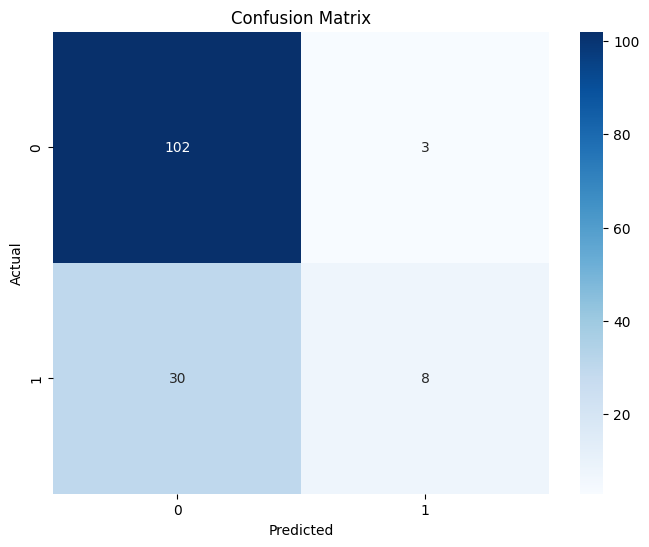

In [33]:
# List to hold the results for varying the number of trees
results = []

# Vary the number of trees from 1 to 100
for n_trees in range(1, 101):
    # Initialize the Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    
    # Fit the model on the training data
    rf_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((n_trees, accuracy))

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results, columns=['n_trees', 'accuracy'])

# Find the best number of trees
best_n_trees = results_df.loc[results_df['accuracy'].idxmax()]['n_trees']
print(f"Best number of trees: {best_n_trees}")

# Fit the final model with the best number of trees
final_rf_model = RandomForestClassifier(n_estimators=int(best_n_trees), random_state=42)
final_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_final = final_rf_model.predict(X_test)

# Generate evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Best number of trees for Random Forest: 3.0
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       105
           1       0.73      0.21      0.33        38

    accuracy                           0.77       143
   macro avg       0.75      0.59      0.59       143
weighted avg       0.76      0.77      0.72       143



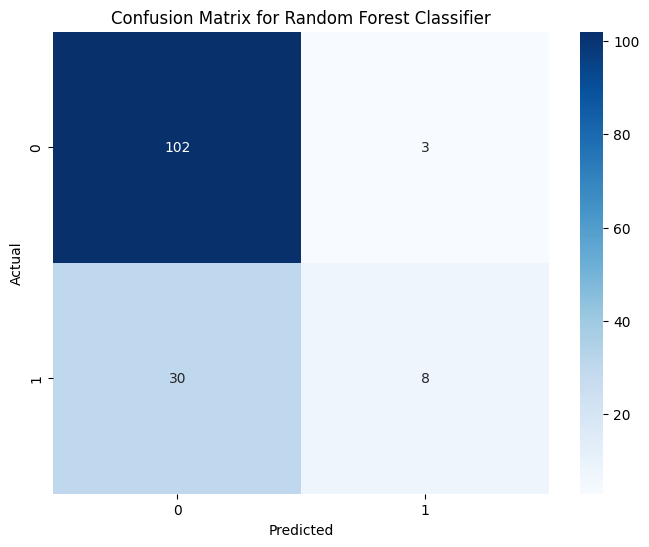

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMet

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       105
           1       0.00      0.00      0.00        38

    accuracy                           0.73       143
   macro avg       0.37      0.50      0.42       143
weighted avg       0.54      0.73      0.62       143



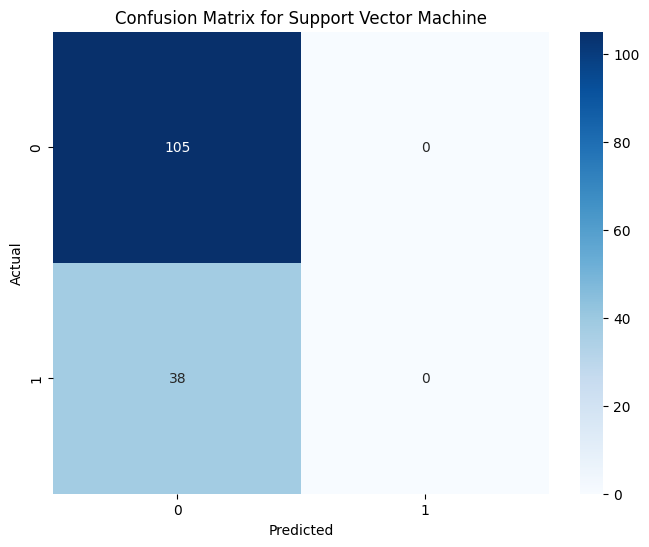

Best number of trees for Gradient Boosting: 12.0
Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       105
           1       1.00      0.03      0.05        38

    accuracy                           0.74       143
   macro avg       0.87      0.51      0.45       143
weighted avg       0.81      0.74      0.64       143



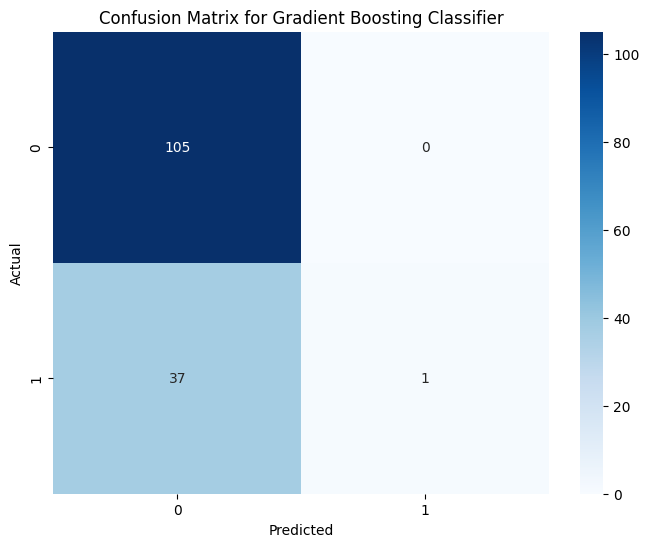


Comparison of Model Performance:
                              Accuracy  Precision    Recall
Random Forest Classifier      0.769231   0.727273  0.210526
Support Vector Machine        0.734266   0.000000  0.000000
Gradient Boosting Classifier  0.741259   1.000000  0.026316


In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to store the results
results_summary = {}

# Define a function to evaluate a model
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Generate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Store results
    results_summary[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


# Support Vector Machine (SVM)
svm_model = SVC()
evaluate_model(svm_model, "Support Vector Machine", X_train, y_train, X_test, y_test)

# Gradient Boosting Classifier
results_gb = []
# Vary the number of trees for Gradient Boosting
for n_trees in range(1, 101):
    gb_model = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results_gb.append((n_trees, accuracy))

# Convert results to a DataFrame for easy analysis
results_gb_df = pd.DataFrame(results_gb, columns=['n_trees', 'accuracy'])
best_n_trees_gb = results_gb_df.loc[results_gb_df['accuracy'].idxmax()]['n_trees']
print(f"Best number of trees for Gradient Boosting: {best_n_trees_gb}")

final_gb_model = GradientBoostingClassifier(n_estimators=int(best_n_trees_gb), random_state=42)
evaluate_model(final_gb_model, "Gradient Boosting Classifier", X_train, y_train, X_test, y_test)

# Print the summary table of results
results_df = pd.DataFrame(results_summary).T
print("\nComparison of Model Performance:")
print(results_df)
